# Treinamento

In [1]:
treinar = {
    'GP': True
}

## Conjunto de dados

In [2]:
import pandas as pd

dataset = pd.read_csv('housesToRentProcessed.csv')

X = dataset[[
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
y = dataset[['y con + alu']].values

### Separação de treino e teste

Os dados foram separados em treino e em teste seguindo a proporção de $70\%$ para treino e de $30\%$ para testes. O processo de seleção do modelo será descrito posteriormente.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Quantidade de elementos para o treinamento:', X_train.shape)
print('Quantidade de elementos selecionados para teste:', X_test.shape)

Quantidade de elementos para o treinamento: (7484, 13)
Quantidade de elementos selecionados para teste: (3208, 13)


### Normalização

A normalização aplicada no conjunto de dados foi a [min/max scalling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler):
\begin{aligned}
\mathcal{D}_{std} &= \frac{\mathcal{D} - \mathcal{D}.min(axis=0)}{\mathcal{D}.max(axis=0) - \mathcal{D}.min(axis=0)}; \\
\mathcal{D}_{scaled} &= \mathcal{D}_{std} \cdot (max - min) + min.
\end{aligned}
A transformação aplicada, escala (dimensiona) e translada cada característica individualmente, de modo que esta esteja entre o intervalo $[0, 1]$.

Como poderá ser visto adiante, este trabalho tomou o cuidado dos dados de validação e de teste serem transformados conforme os dados  a escala definida no treinamento.

In [4]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler

## Treinamento

Com o intuito de selecionar os melhores hiperparâmetros, para cada um dos modelo testados, foi realizado uma validação cruzada por meio de _5-folds_, onde ocorreu uma otimização bayesiana em cada um dos _folds_. Os hiperparâmetros foram selecionados de acordo com o resultado da métrica **DECIDIR**, descrita a seguir.

Após a seleção dos hiperparâmetros, cada um dos modelos foram avaliados com conjunto de testes por meio das métricas descritas a seguir.

### Métricas

#### Root Mean Squared Error (RMSE)

__Root Mean Squared Error__ ou raiz do erro médio quadrático [_terminar_]

In [5]:
from sklearn.metrics import mean_squared_error

rmse = lambda a, b: mean_squared_error(a, b, squared=False)

#### NLPD

## Modelos utilizados

### Processos Gaussianos

#### Hiperparâmetros a serem procurados

In [6]:
from trabalho.util.otimizacao_bayesiana import Dominio
import gpflow


kernels = [
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
    gpflow.kernels.Linear(),
    gpflow.kernels.SquaredExponential()
]


dominio = Dominio([
    # https://gpflow.readthedocs.io/en/master/gpflow/kernels/#gpflow-kernels-linear
    {
        'name': 'kernel',
        'type': 'discrete',
        'domain': [
            gpflow.kernels.Matern12(),
            gpflow.kernels.Matern32(),
            gpflow.kernels.Matern52(),
            gpflow.kernels.Linear(),
            gpflow.kernels.SquaredExponential()
        ]
    },
#     {'name': 'learning_rate',   'type': 'continuous', 'domain': (0.0001, 0.02)},
#     {'name': 'sampling_method', 'type': 'discrete',   'domain': (1, 3, 5)},
#     {'name': 'regularization',  'type': 'continuous', 'domain': (0.00001, 0.01)},
#     {'name': 'batch_size',      'type': 'discrete',   'domain': (10, 16, 32)},
])

dominio.dominio

[{'name': 'kernel', 'type': 'discrete', 'domain': [0, 1, 2, 3, 4]}]

In [7]:
from trabalho.modelos.gp import GP

GP

trabalho.modelos.gp.GP

0
RMSE: 0.0030331675654021724 (normalizado)
RMSE: 3875.0547876303053 ("real")
Parâmetros: [3.]


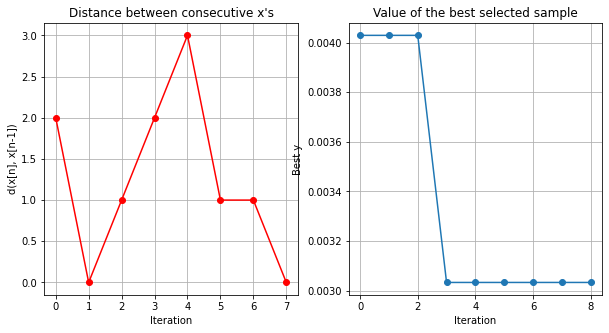

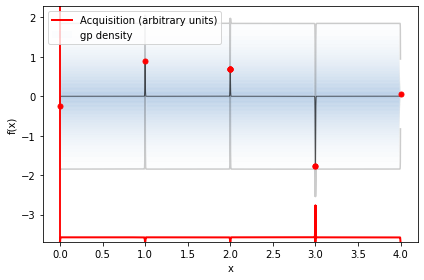

1
RMSE: 0.003051523515548841 (normalizado)
RMSE: 3895.6007861889734 ("real")
Parâmetros: [3.]


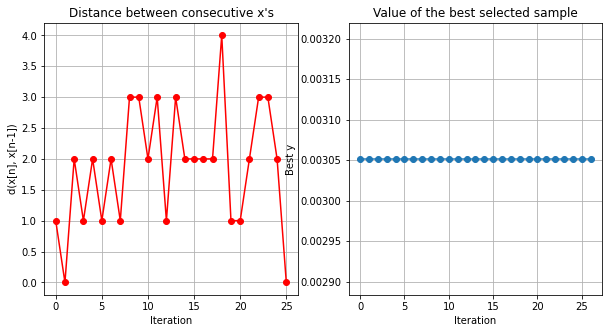

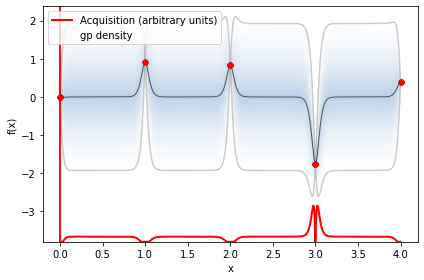

2
RMSE: 0.0027933274129074708 (normalizado)
RMSE: 3606.599306541461 ("real")
Parâmetros: [0.]


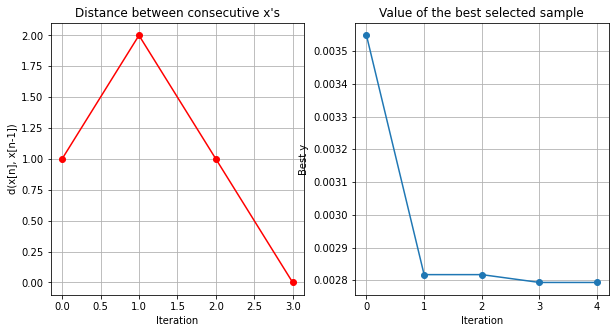

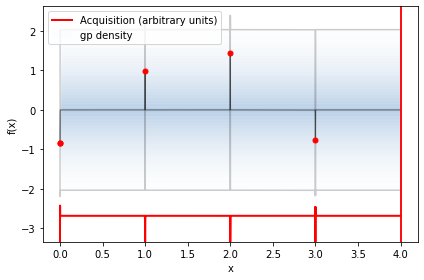

3
RMSE: 0.020281946505676253 (normalizado)
RMSE: 23181.78554326849 ("real")
Parâmetros: [0.]


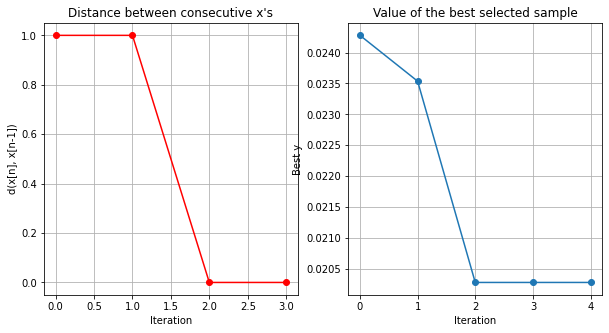

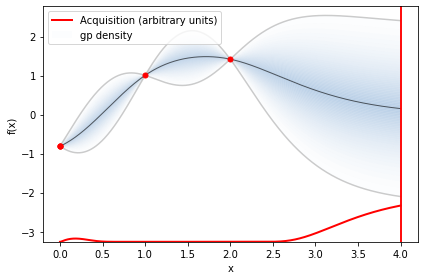

4
RMSE: 0.019530911293519533 (normalizado)
RMSE: 22360.75370172348 ("real")
Parâmetros: [0.]


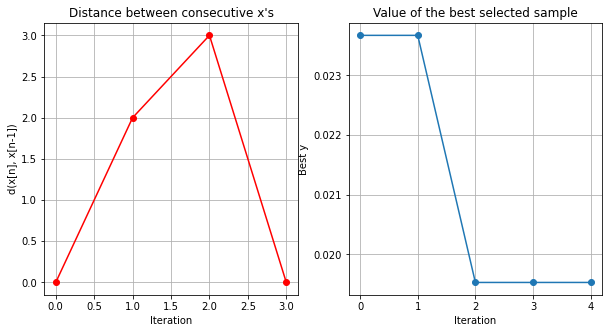

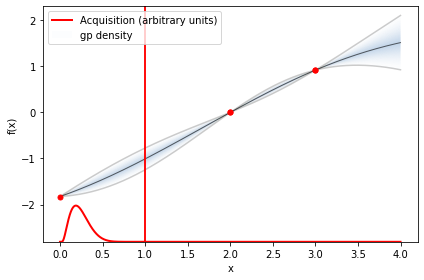

In [8]:
#!pip install tqdm
from trabalho.util.kfold import KFoldCrossValidation
from GPyOpt.methods import BayesianOptimization


def f(Modelo, X, y, X_validation, y_validation, **kwargs):
    modelo = Modelo(**kwargs)
    modelo.fit(X, y)
    
    means, vars = modelo.predict(X_validation)
    y_pred = means

    return rmse(y_pred, y_validation)


def validacao_cruzada(Modelo, dominio, X, y, max_iter=25, k_folds=5):
    #for i, X_train, X_test, y_train, y_test in tqdm(KFoldCrossValidation(X, y, k_folds).split()):
    for i, X_train, X_test, y_train, y_test in KFoldCrossValidation(X, y, k_folds).split():
        print(i)
        X_scaler = Scaler()
        y_scaler = Scaler()
        
        X            = X_scaler.fit_transform(X_train)
        X_validation = X_scaler.transform(X_test)
        y            = y_scaler.fit_transform(y_train)
        y_validation = y_scaler.transform(y_test)

        funcao = dominio.gerar_f(Modelo=Modelo, f=f, X=X, y=y, X_validation=X_validation, y_validation=y_validation)
        
        bo = BayesianOptimization(f=funcao, domain=dominio.dominio, verbosity=True)
        bo.run_optimization(max_iter=25)

        print('RMSE:', bo.fx_opt, '(normalizado)')
        print('RMSE:', y_scaler.inverse_transform([[bo.fx_opt]])[0, 0], '("real")')
        print('Parâmetros:', bo.x_opt)
        bo.plot_convergence()
        bo.plot_acquisition()

if treinar['GP']:
    validacao_cruzada(Modelo=GP, dominio=dominio, X=X_train, y=y_train)

In [9]:
s = Scaler()
s.inverse_transform

<bound method MinMaxScaler.inverse_transform of MinMaxScaler()>